### Install/Import The Libraries

In [74]:
# Uncomment the rows if necessary - Requirements.txt
# %pip install -r requirements.txt

In [75]:
import os 
import math 
import random
import numpy as np
import kagglehub
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from scipy.ndimage import label
from dataclasses import dataclass, asdict
from typing import Callable, Iterable, List, Optional, Tuple, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms.functional as TF

print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch: 2.8.0+cpu
CUDA available: False


In [76]:
# Download latest version
path = kagglehub.dataset_download("nikhilpandey360/chest-xray-masks-and-labels")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\tkaramyan\.cache\kagglehub\datasets\nikhilpandey360\chest-xray-masks-and-labels\versions\1


In [77]:
def print_tree(startpath:str, prefix:str="") -> None:
    '''
    Helper function to see what's inside the Folder
    '''
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, "").count(os.sep)
        indent = " " * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = " " * 4 * (level + 1)
        # for f in files:
        #     print(f"{subindent}{f}")

print_tree(path)

1/
    data/
        Lung Segmentation/
            .ipynb_checkpoints/
            ClinicalReadings/
            CXR_png/
            masks/
            test/
    Lung Segmentation/
        .ipynb_checkpoints/
        ClinicalReadings/
        CXR_png/
        masks/
        test/


It seems that the folder is duplicated: so we will continue with Lung Segmentation Folder

### Parameters

In [78]:
@dataclass
class Config:
    # main
    root_dir: Path = Path(os.path.join(path, "Lung Segmentation")).resolve()
    img_dir: Path = root_dir/"CXR_png"
    msk_dir: Path = root_dir/"masks"
    inference_dir: Path = root_dir/"test"
    img_ext: str = ".png"
    msk_ext: str = ".png"
    img_size: Tuple[int, int] = (512, 512) # (h, w)
    in_channels: int = 1
    num_classes: int = 3 # bg, left, right
    base_channels: int = 16 # Originally 32 by too slow on CPU
    depth: int = 3 # UNet depth (down/up steps): Originally 4 by complex for CPU
    batch_size: int = 8
    lr: float = 1e-2
    weight_decay: float = 1e-5
    max_epochs: int = 30
    val_split: float = 0.1
    test_split: float = 0.1
    num_workers: int = 0
    seed: int = 42
    # normalization for grayscale images
    mean: float = 0.5
    std: float = 0.5
    # augmentations
    hflip_p: float = 0.5
    rotate_deg: float = 5.0
    jitter_p: float = 0.5
    noise_p: float = 0.3
    log_every: int = 1 # print every N train batches
    ckpt_path: Path = Path("best_unet.pt")

cfg = Config()

In [79]:
def set_seed(seed: int) -> None:
    '''
    Helper function for reproducibility
    '''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False 
    torch.backends.cudnn.benchmark = True

set_seed(cfg.seed)

In [80]:
# In my case CPU is the only choice 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data Healthcheck

In [81]:
PALETTE = {
    0: (0,   0,   0),
    1: (0,  255,   0),
    2: (255, 20, 255),
}

In [82]:
def mask_image_to_ndarray(mask: Image.Image, blend_alpha: float = 0.4) -> np.ndarray:
    a = int(round(255 * float(blend_alpha)))
    alpha_img = mask.convert("L").point(lambda p: a if p > 0 else 0)
    alpha_arr = np.array(alpha_img, dtype=np.uint8)
    return alpha_arr

In [83]:
def colorize_mask(mask: np.ndarray, palette: Dict[int, Tuple[int,int,int]] = PALETTE) -> Image.Image:
    h, w = mask.shape
    out = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, col in palette.items():
        out[mask == cls] = col
    return Image.fromarray(out, mode="RGB")

In [84]:
def overlay_multiclass_on_image(img: Image.Image,
                                mask: np.ndarray,
                                alpha: float = 0.35,
                                palette: Dict[int, Tuple[int,int,int]] = PALETTE) -> Image.Image:
    
    base = img.convert("RGB").convert("RGBA")
    color = colorize_mask(mask, palette).convert("RGBA")
    m = Image.fromarray((mask > 0).astype(np.uint8) * int(round(255 * alpha)), mode="L")
    color.putalpha(m)
    return Image.alpha_composite(base, color).convert("RGB")

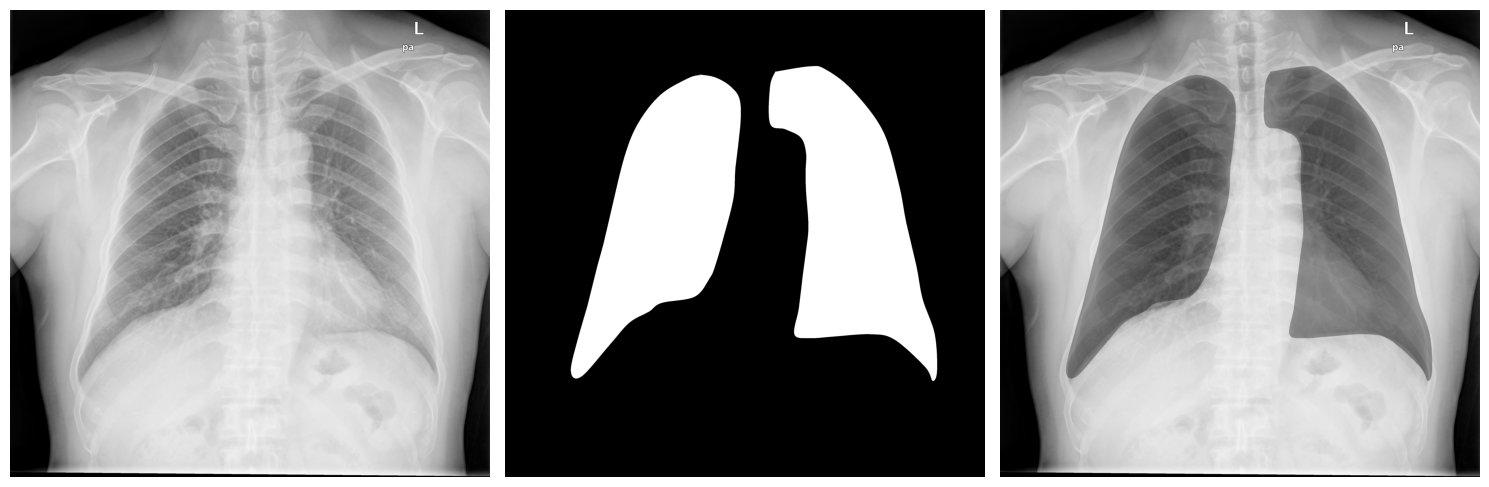

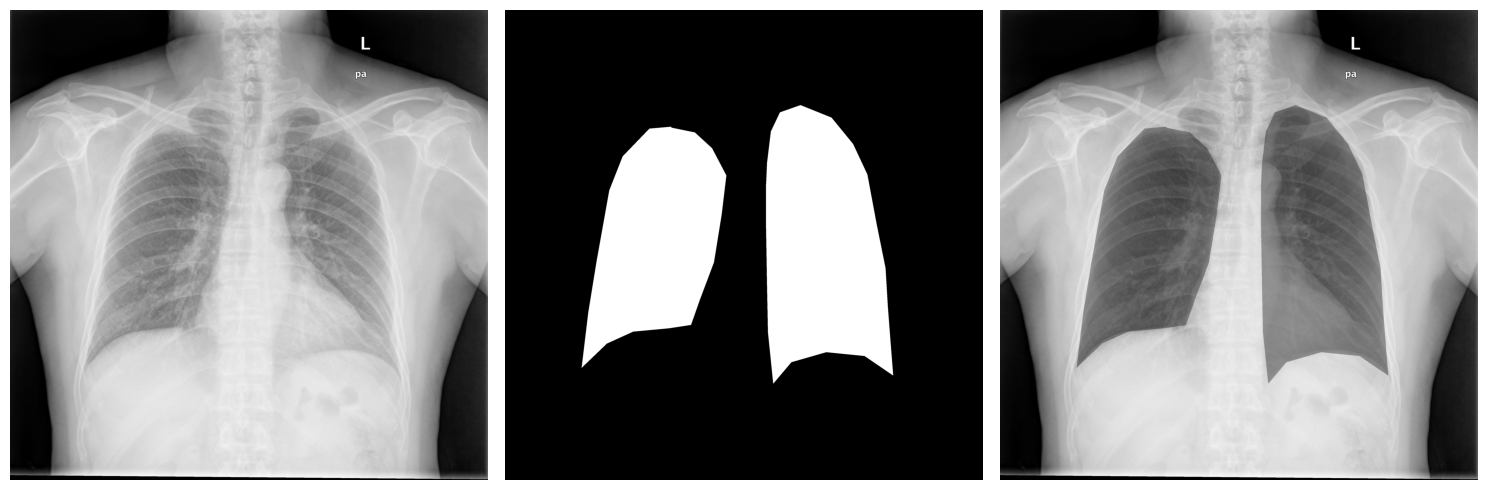

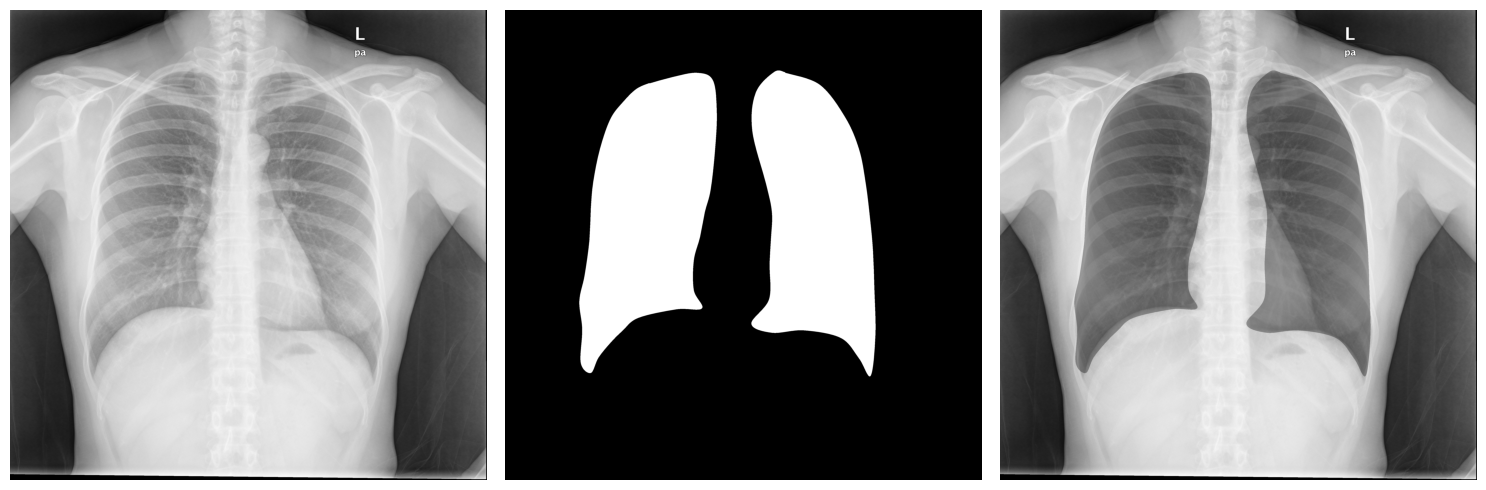

In [85]:
# Check the images for 2-3 examples
filenames = next(os.walk(cfg.img_dir))[2][:3]
for file in filenames:
    filename = Path(file).stem
    
    img = Image.open(cfg.img_dir / (filename + '.png'))
    msk = Image.open(cfg.msk_dir / (filename + '_mask.png'))

    msk_array = mask_image_to_ndarray(msk)
    colored = overlay_multiclass_on_image(img, msk_array)

    plt.figure(figsize=(15,5))

    plt.subplot(131); plt.imshow(img); plt.yticks([]); plt.xticks([]); plt.box(False)
    plt.subplot(132); plt.imshow(msk, cmap='binary_r'); plt.yticks([]); plt.xticks([]); plt.box(False)
    plt.subplot(133); plt.imshow(colored); plt.yticks([]); plt.xticks([]); plt.box(False)

    plt.tight_layout()
    plt.show()

### Mask Utils: Functions to create three class labels

In [86]:
def to_numpy_mask(mask_img: Image.Image) -> np.ndarray:
    """
    Convert a binary mask PIL image to numpy array of {0,1}.
    Accepts masks as 0/255 or 0/1.
    """
    m = np.array(mask_img.convert("L"))
    m = (m > 0).astype(np.uint8)
    return m

In [87]:
def _two_means_split(xs: np.ndarray, max_iter: int = 30) -> Tuple[float, float, np.ndarray]:
    """
    Tiny 1D k=2 means for x-coordinates; returns centers (c1, c2) and labels {0,1}.
    """
    assert xs.ndim == 1 and xs.size > 0
    c1, c2 = np.percentile(xs, [25, 75]).astype(np.float32)
    for _ in range(max_iter):
        d1 = np.abs(xs - c1)
        d2 = np.abs(xs - c2)
        lab = (d2 < d1).astype(np.uint8)
        new_c1 = xs[lab == 0].mean() if np.any(lab == 0) else c1
        new_c2 = xs[lab == 1].mean() if np.any(lab == 1) else c2
        if abs(new_c1 - c1) < 1e-3 and abs(new_c2 - c2) < 1e-3:
            break
        c1, c2 = new_c1, new_c2
    return float(c1), float(c2), lab

In [88]:
def binary_to_three_class(bin_mask: np.ndarray,
                          left_class: int = 1,
                          right_class: int = 2) -> np.ndarray:
    """
    Convert a binary lung mask (0/1) to 3-class:
      0=bg, 1=left (image-left), 2=right (image-right).

    Strategy:
      - Find connected components; if ≥2 components, take two largest -> left/right by centroid x.
      - If only 1 component, split foreground pixels into two groups by 1D k-means on x.
      - If >2, assign extra comps to nearest center by x-position.
    """
    h, w = bin_mask.shape
    out = np.zeros((h, w), dtype=np.uint8)
    if bin_mask.sum() == 0:
        return out  # background only

    lab, n = label(bin_mask)
    if n == 1:
        ys, xs = np.where(bin_mask > 0)
        _, _, klabels = _two_means_split(xs.astype(np.float32))
        # map by image-left/image-right
        left_idx = xs[klabels == 0]
        right_idx = xs[klabels == 1]
        left_mask = np.zeros_like(bin_mask, dtype=bool)
        right_mask = np.zeros_like(bin_mask, dtype=bool)
        left_mask[ys[klabels == 0], xs[klabels == 0]] = True
        right_mask[ys[klabels == 1], xs[klabels == 1]] = True

        out[left_mask] = left_class
        out[right_mask] = right_class
        return out

    # n >= 2: sort components by area
    areas = []
    for i in range(1, n + 1):
        areas.append((i, int((lab == i).sum())))
    areas.sort(key=lambda t: t[1], reverse=True)

    # Use two largest as lungs
    main_ids = [areas[0][0], areas[1][0]] if n >= 2 else [areas[0][0]]
    centroids_x = {}
    for i in main_ids:
        ys, xs = np.where(lab == i)
        centroids_x[i] = xs.mean() if xs.size else math.inf

    # Assign left/right by centroid x
    if len(main_ids) == 1:
        # edge case fallback to k-means
        return binary_to_three_class(bin_mask, left_class, right_class)
    left_id, right_id = sorted(main_ids, key=lambda i: centroids_x[i])

    out[lab == left_id] = left_class
    out[lab == right_id] = right_class

    # If there are extra small components, attach them to neaest side by x
    for i in range(1, n + 1):
        if i in main_ids:
            continue
        ys, xs = np.where(lab == i)
        if xs.size == 0:
            continue
        cx = xs.mean()
        assign = left_class if abs(cx - centroids_x[left_id]) <= abs(cx - centroids_x[right_id]) else right_class
        out[lab == i] = assign

    return out


### Augmentations

In [89]:
class DualTransform:
    def __call__(self, img: Image.Image, msk: np.ndarray):
        raise NotImplementedError

In [90]:
class RandomHorizontalFlipSwap(DualTransform):
    """Horizontal flip; if flipped, swap left/right labels 1<->2 in the mask."""
    def __init__(self, p: float = 0.5, left_label: int = 1, right_label: int = 2):
        self.p = p
        self.left_label = left_label
        self.right_label = right_label

    def __call__(self, img: Image.Image, msk: np.ndarray):
        if random.random() < self.p:
            img = TF.hflip(img)
            msk = np.ascontiguousarray(msk[:, ::-1])
            # swap labels
            swap = msk.copy()
            msk[swap == self.left_label] = self.right_label
            msk[swap == self.right_label] = self.left_label
        return img, msk

In [91]:
class RandomJitter(DualTransform):
    """Random brightness/contrast jitter on image only."""
    def __init__(self, p: float = 0.5, brightness: float = 0.2, contrast: float = 0.2):
        self.p = p
        self.brightness = brightness
        self.contrast = contrast

    def __call__(self, img: Image.Image, msk: np.ndarray) -> Tuple[Image.Image, np.ndarray]:
        if random.random() < self.p:
            # brightness
            b = 1.0 + random.uniform(-self.brightness, self.brightness)
            img = TF.adjust_brightness(img, b)
            # contrast
            c = 1.0 + random.uniform(-self.contrast, self.contrast)
            img = TF.adjust_contrast(img, c)
        return img, msk

In [92]:
class RandomRotate(DualTransform):
    """Small random rotation; bilinear for image, nearest for mask."""
    def __init__(self, degrees: float = 5.0):
        self.degrees = degrees

    def __call__(self, img: Image.Image, msk: np.ndarray):
        angle = random.uniform(-self.degrees, self.degrees)
        img = TF.rotate(img, angle, interpolation=TF.InterpolationMode.BILINEAR, fill=0)
        msk_img = Image.fromarray(msk, mode="L")
        msk_img = TF.rotate(msk_img, angle, interpolation=TF.InterpolationMode.NEAREST, fill=0)
        msk = np.array(msk_img)
        return img, msk

In [93]:
class RandomGaussianNoise(DualTransform):
    """Additive Gaussian noise to image only."""
    def __init__(self, p: float = 0.3, sigma_range: Tuple[float, float] = (0.001, 0.01)):
        self.p = p
        self.sigma_range = sigma_range

    def __call__(self, img: Image.Image, msk: np.ndarray):
        if random.random() < self.p:
            arr = np.array(img).astype(np.float32) / 255.0
            sigma = random.uniform(*self.sigma_range)
            arr = arr + np.random.normal(0, sigma, size=arr.shape).astype(np.float32)
            arr = np.clip(arr, 0.0, 1.0)
            img = Image.fromarray((arr * 255.0).astype(np.uint8))
        return img, msk

In [94]:
class ComposeDual(DualTransform):
    def __init__(self, transforms: List[DualTransform]):
        self.transforms = transforms

    def __call__(self, img: Image.Image, msk: np.ndarray):
        for t in self.transforms:
            img, msk = t(img, msk)
        return img, msk

### DataSet

In [95]:
class ShenzhenLungDataset(Dataset):
    """
    Loads CXR images and **binary** masks, converts to 3-class mask (0,1,2),
    resizes, normalizes, and applies augmentations.
    """
    def __init__(self,
                 img_dir: Path,
                 msk_dir: Path,
                 filenames: Optional[List[str]] = None,
                 img_size: Tuple[int, int] = (512, 512),
                 mean: float = 0.5,
                 std: float = 0.5,
                 augment: Optional[DualTransform] = None):
        
        self.img_dir = Path(img_dir)
        self.msk_dir = Path(msk_dir)
        if filenames is None:
            img_files = {p.name for p in self.img_dir.iterdir() if p.is_file()}
            msk_files = {f"{Path(p.name).stem}_mask.png" for p in self.msk_dir.iterdir() if p.is_file()}
            common = sorted(img_files & msk_files)
            self.files = common
        else:
            self.files = filenames
        self.img_size = img_size
        self.mean = mean
        self.std = std
        self.augment = augment

    def __len__(self):
        return len(self.files)

    def _load_pair(self, fname: str):
        img_path = self.img_dir / fname
        stem = Path(fname).stem                  
        msk_path = self.msk_dir / f"{stem}_mask.png"
        
        img = Image.open(img_path).convert("L")
        msk_bin = to_numpy_mask(Image.open(msk_path))
        msk3 = binary_to_three_class(msk_bin)
        return img, msk3

    def _resize_pair(self, img: Image.Image, msk: np.ndarray):
        H, W = self.img_size
        img = img.resize((W, H), resample=Image.BILINEAR)
        msk_img = Image.fromarray(msk, mode="L").resize((W, H), resample=Image.NEAREST)
        msk = np.array(msk_img)
        return img, msk

    def __getitem__(self, idx: int):
        fname = self.files[idx]
        img, msk = self._load_pair(fname)
        img, msk = self._resize_pair(img, msk)

        if self.augment is not None:
            img, msk = self.augment(img, msk)

        # To tensors
        img_t = TF.to_tensor(img) # [1,h,w], float32 0-1
        img_t = TF.normalize(img_t, [cfg.mean], [cfg.std])

        msk_t = torch.from_numpy(msk.astype(np.int64)) # [h,w], long with {0,1,2}

        return {
            "image": img_t, # [c,h,w]
            "mask": msk_t, # [h,w]
            "filename": fname,
        }

### Model

In [96]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x: torch.Tensor):
        return self.block(x)

In [97]:
class Down(nn.Module):
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.block = nn.Sequential(nn.MaxPool2d(2), ConvBlock(in_ch, out_ch))
    def forward(self, x: torch.Tensor):
        return self.block(x)

class Up(nn.Module):
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = ConvBlock(in_ch, out_ch)
    def forward(self, x: torch.Tensor, skip: torch.Tensor):
        x = self.up(x)
        dh = skip.size(2) - x.size(2)
        dw = skip.size(3) - x.size(3)
        if dh != 0 or dw != 0:
            x = F.pad(x, [dw // 2, dw - dw // 2, dh // 2, dh - dh // 2])
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

In [98]:
class UNet(nn.Module):
    def __init__(self, in_ch: int = 1, num_classes: int = 3, base_ch: int = 32, depth: int = 4):
        super().__init__()
        # how deep it should go down: original - 4
        chs = [base_ch * (2 ** i) for i in range(depth + 1)]

        self.inc = ConvBlock(in_ch, chs[0])
        self.downs = nn.ModuleList([Down(chs[i], chs[i+1]) for i in range(depth)])
        self.ups = nn.ModuleList([Up(chs[i+1], chs[i]) for i in reversed(range(depth))])
        self.outc = nn.Conv2d(chs[0], num_classes, kernel_size=1)

    def forward(self, x: torch.Tensor):
        feats = [self.inc(x)]
        for d in self.downs:
            feats.append(d(feats[-1]))
        x = feats[-1]
        for i, up in enumerate(self.ups):
            x = up(x, feats[-(i+2)])
        return self.outc(x)

### Metrics

In [99]:
@torch.no_grad()
def dice_per_class(logits: torch.Tensor, # [b,c,h,w]
                   target: torch.Tensor, # [b,h,w]
                   num_classes: int,
                   eps: float = 1e-6) -> List[float]:
    
    pred = logits.argmax(dim=1) # [b,h,w]
    dices = []
    for c in range(num_classes):
        p = (pred == c).float()
        t = (target == c).float()
        inter = (p * t).sum()
        denom = p.sum() + t.sum()
        d = (2.0 * inter + eps) / (denom + eps)
        dices.append(float(d))
    return dices

In [100]:
@torch.no_grad()
def iou_per_class(logits: torch.Tensor,
                  target: torch.Tensor,
                  num_classes: int,
                  eps: float = 1e-6) -> List[float]:
    
    pred = logits.argmax(dim=1)
    ious = []
    for c in range(num_classes):
        p = (pred == c).float()
        t = (target == c).float()
        inter = (p * t).sum()
        union = p.sum() + t.sum() - inter
        i = (inter + eps) / (union + eps)
        ious.append(float(i))
    return ious

### Data preparation

In [101]:
all_files = sorted([p.name for p in cfg.img_dir.iterdir() if (cfg.msk_dir / (p.name.split(sep='.')[0] + "_mask" + '.png')).exists()])
assert len(all_files) > 0, "No matching image/mask pairs found."

N = len(all_files)
test_len = int(round(N * cfg.test_split))
val_len = int(round(N * cfg.val_split))
train_len = N - val_len - test_len
perm = np.random.RandomState(cfg.seed).permutation(N)
train_idx = perm[:train_len]
val_idx   = perm[train_len:train_len+val_len]
test_idx  = perm[train_len+val_len:]

train_files = [all_files[i] for i in train_idx]
val_files   = [all_files[i] for i in val_idx]
test_files  = [all_files[i] for i in test_idx]

train_aug = ComposeDual([
    RandomHorizontalFlipSwap(p=cfg.hflip_p),
    RandomRotate(degrees=cfg.rotate_deg),
    RandomJitter(p=cfg.jitter_p),
    RandomGaussianNoise(p=cfg.noise_p),
])

val_aug = None  

train_ds = ShenzhenLungDataset(cfg.img_dir, cfg.msk_dir, filenames=train_files,
                               img_size=cfg.img_size, mean=cfg.mean, std=cfg.std, augment=train_aug)
val_ds   = ShenzhenLungDataset(cfg.img_dir, cfg.msk_dir, filenames=val_files,
                               img_size=cfg.img_size, mean=cfg.mean, std=cfg.std, augment=val_aug)
test_ds  = ShenzhenLungDataset(cfg.img_dir, cfg.msk_dir, filenames=test_files,
                               img_size=cfg.img_size, mean=cfg.mean, std=cfg.std, augment=val_aug)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=False)

### Training

In [26]:
model = UNet(in_ch=cfg.in_channels, num_classes=cfg.num_classes,
             base_ch=cfg.base_channels, depth=cfg.depth).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.5)
criterion = nn.CrossEntropyLoss()
# Guess Early stopping might be a good step to add, since at the end model stops proper learning 

history = {
    "train_loss": [],
    "val_loss": [],
    "val_dice_bg": [], "val_dice_left": [], "val_dice_right": [], "val_dice_mean": [],
    "val_iou_bg": [],  "val_iou_left": [],  "val_iou_right": [],  "val_iou_mean": [],
}

best_metric: float = -1.0
best_epoch: int = -1

In [27]:
for epoch in range(1, cfg.max_epochs + 1):
    model.train()
    run_loss = 0.0
    n_batches = 0
    
    print(f"\nEpoch {epoch:03d}/{cfg.max_epochs} — lr={optimizer.param_groups[0]['lr']:.2e}")
    for bi, batch in enumerate(train_loader, 1):
        img = batch["image"].to(device) # [b,1,h,w]
        msk = batch["mask"].to(device) # [b,h,w], long {0,1,2}

        optimizer.zero_grad()
        logits = model(img) # [b,3,h,w]
        loss = criterion(logits, msk)
        loss.backward()
        optimizer.step()

        run_loss += loss.item()
        n_batches += 1

        if (bi % cfg.log_every == 0) or (bi == len(train_loader)):
            avg = run_loss / n_batches
            print(f"  train: batch {bi:4d}/{len(train_loader):4d} | loss={loss.item():.4f} | avg={avg:.4f}")

    train_loss = run_loss / max(1, n_batches)
    history["train_loss"].append(train_loss)

    model.eval()
    val_run_loss = 0.0
    nb = 0
    dices_accum = np.zeros(cfg.num_classes, dtype=np.float64)
    ious_accum = np.zeros(cfg.num_classes, dtype=np.float64)
    n_batches_val = 0

    with torch.no_grad():
        for batch in val_loader:
            img = batch["image"].to(device)
            msk = batch["mask"].to(device)
            logits = model(img)
            loss = criterion(logits, msk)
            val_run_loss += loss.item()
            n_batches_val += 1

            dpc = dice_per_class(logits, msk, cfg.num_classes)
            ipc = iou_per_class (logits, msk, cfg.num_classes)
            dices_accum += np.array(dpc)
            ious_accum  += np.array(ipc)

    val_loss = val_run_loss / max(1, n_batches_val)
    dices_mean = (dices_accum / max(1, n_batches_val)).tolist()
    ious_mean  = (ious_accum  / max(1, n_batches_val)).tolist()

    history["val_loss"].append(val_loss)
    history["val_dice_bg"].append(dices_mean[0])
    history["val_dice_left"].append(dices_mean[1])
    history["val_dice_right"].append(dices_mean[2])
    history["val_dice_mean"].append(sum(dices_mean)/len(dices_mean))
    history["val_iou_bg"].append(ious_mean[0])
    history["val_iou_left"].append(ious_mean[1])
    history["val_iou_right"].append(ious_mean[2])
    history["val_iou_mean"].append(sum(ious_mean)/len(ious_mean))

    scheduler.step(val_loss)
    print(f"  val:   loss={val_loss:.4f} | "
          f"Dice(bg/left/right/mean)=({dices_mean[0]:.3f}/{dices_mean[1]:.3f}/{dices_mean[2]:.3f}/{history['val_dice_mean'][-1]:.3f}) | "
          f"IoU(mean)={history['val_iou_mean'][-1]:.3f}")

    print(f"Epoch {epoch:03d}/{cfg.max_epochs} | "
          f"train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | "
          f"Dice(mean)={history['val_dice_mean'][-1]:.3f} | "
          f"IoU(mean)={history['val_iou_mean'][-1]:.3f}")

    if history["val_dice_mean"][-1] > best_metric:
            best_metric = history["val_dice_mean"][-1]
            best_epoch = epoch
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "cfg": asdict(cfg),
                "val_dice_mean": best_metric,
            }, cfg.ckpt_path)
            print(f"Best Checkout in {cfg.ckpt_path} (val Dice(mean)={best_metric:.3f})")
    
    print(f"Best epoch: {best_epoch} | best val Dice(mean): {best_metric:.3f}")


Epoch 001/30 — lr=1.00e-02
  train: batch    1/  57 | loss=1.1179 | avg=1.1179
  train: batch    2/  57 | loss=1.0215 | avg=1.0697
  train: batch    3/  57 | loss=0.8792 | avg=1.0062
  train: batch    4/  57 | loss=0.8410 | avg=0.9649
  train: batch    5/  57 | loss=0.7616 | avg=0.9242
  train: batch    6/  57 | loss=0.6918 | avg=0.8855
  train: batch    7/  57 | loss=0.6624 | avg=0.8536
  train: batch    8/  57 | loss=0.6235 | avg=0.8249
  train: batch    9/  57 | loss=0.6464 | avg=0.8050
  train: batch   10/  57 | loss=0.5937 | avg=0.7839
  train: batch   11/  57 | loss=0.6016 | avg=0.7673
  train: batch   12/  57 | loss=0.5173 | avg=0.7465
  train: batch   13/  57 | loss=0.5818 | avg=0.7338
  train: batch   14/  57 | loss=0.6541 | avg=0.7281
  train: batch   15/  57 | loss=0.6002 | avg=0.7196
  train: batch   16/  57 | loss=0.5909 | avg=0.7116
  train: batch   17/  57 | loss=0.5876 | avg=0.7043
  train: batch   18/  57 | loss=0.5747 | avg=0.6971
  train: batch   19/  57 | loss=0.50

### Evaluation

In [102]:
@torch.no_grad()
def evaluate(loader: DataLoader, name: str = "test") -> Dict[str, float]:
    """Compute loss, Dice per class, IoU per class; returns summary dict and prints nicely."""
    model.eval()
    total_loss = 0.0
    dices = np.zeros(cfg.num_classes, dtype=np.float64)
    ious  = np.zeros(cfg.num_classes, dtype=np.float64)
    nb = 0

    for batch in loader:
        img = batch["image"].to(device)
        msk = batch["mask"].to(device)
        logits = model(img)
        loss = criterion(logits, msk)
        total_loss += loss.item()
        nb += 1
        dices += np.array(dice_per_class(logits, msk, cfg.num_classes))
        ious  += np.array(iou_per_class (logits, msk, cfg.num_classes))

    total_loss /= max(1, nb)
    dices /= max(1, nb)
    ious  /= max(1, nb)

    summary = {
        "loss": total_loss,
        "dice_bg": float(dices[0]), "dice_left": float(dices[1]), "dice_right": float(dices[2]),
        "dice_mean": float(dices.mean()),
        "iou_bg": float(ious[0]),   "iou_left": float(ious[1]),   "iou_right": float(ious[2]),
        "iou_mean": float(ious.mean()),
    }
    print(f"\n{name.upper()} — loss={summary['loss']:.4f} | "
          f"Dice(bg/left/right/mean)=({summary['dice_bg']:.3f}/{summary['dice_left']:.3f}/{summary['dice_right']:.3f}/{summary['dice_mean']:.3f}) | "
          f"IoU(mean)={summary['iou_mean']:.3f}")
    return summary

In [103]:
evaluate(test_loader, name="test")


TEST — loss=0.0568 | Dice(bg/left/right/mean)=(0.987/0.965/0.952/0.968) | IoU(mean)=0.938


{'loss': 0.056788548827171326,
 'dice_bg': 0.9866570457816124,
 'dice_left': 0.9649576842784882,
 'dice_right': 0.9521139115095139,
 'dice_mean': 0.9679095471898714,
 'iou_bg': 0.9736899882555008,
 'iou_left': 0.9323887005448341,
 'iou_right': 0.9088766202330589,
 'iou_mean': 0.9383184363444647}

### Visualisation

In [104]:
@torch.no_grad()
def visualize_test_examples(dl: DataLoader, n_cases: int = 5) -> None:
    model.eval()
    shown = 0
    for batch in dl:
        img_t = batch["image"]
        gt_t  = batch["mask"]
        logits = model(img_t.to(device))
        pred  = logits.argmax(dim=1).cpu()

        B = img_t.size(0)
        for i in range(B):
            if shown >= n_cases:
                return
            show = img_t[i, 0].cpu().numpy() * cfg.std + cfg.mean
            show = np.clip(show, 0, 1)
            img_pil = Image.fromarray((show * 255).astype(np.uint8), mode="L")

            gt_np = gt_t[i].cpu().numpy().astype(np.uint8)
            pr_np = pred[i].cpu().numpy().astype(np.uint8)

            plt.figure(figsize=(12, 4))
            plt.subplot(131); plt.imshow(img_pil, cmap="gray"); plt.title("Input"); plt.axis("off")
            plt.subplot(132); plt.imshow(colorize_mask(gt_np)); plt.title("GT (0/1/2)"); plt.axis("off")
            plt.subplot(133); plt.imshow(colorize_mask(pr_np)); plt.title("Pred (0/1/2)"); plt.axis("off")
            plt.tight_layout(); plt.show()

            shown += 1

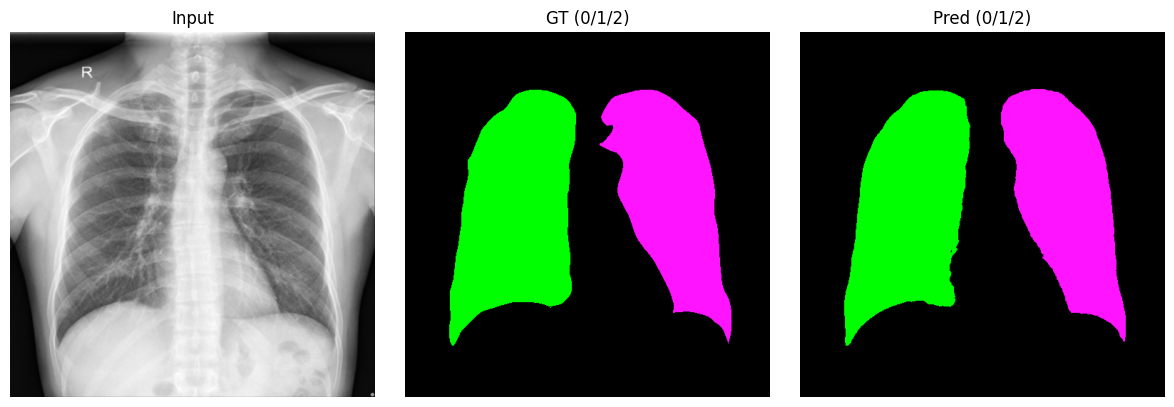

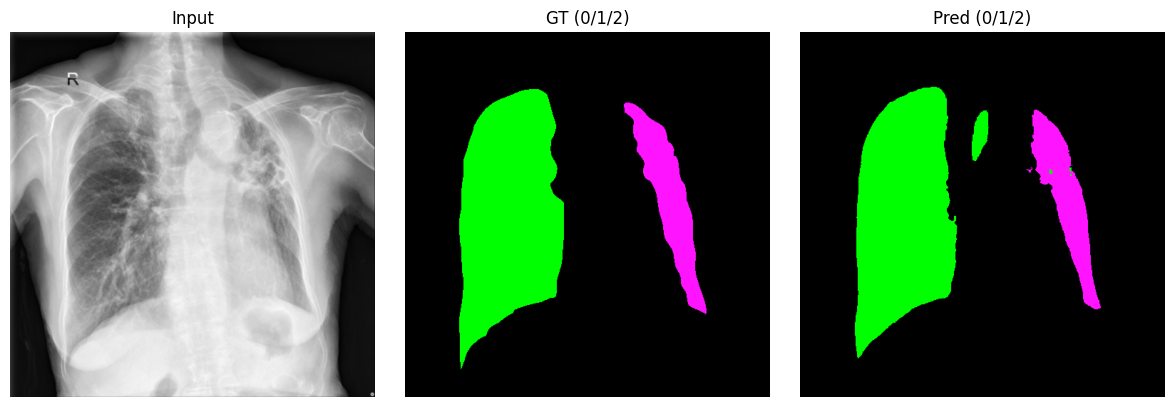

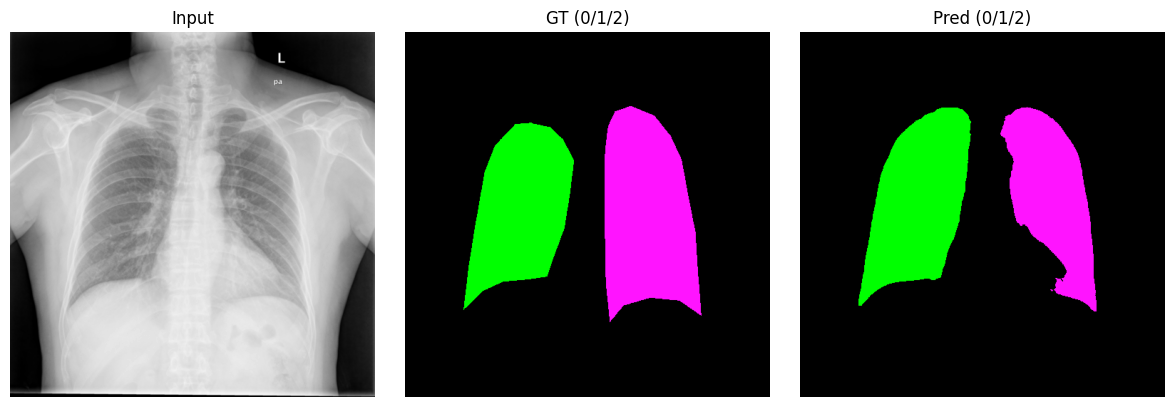

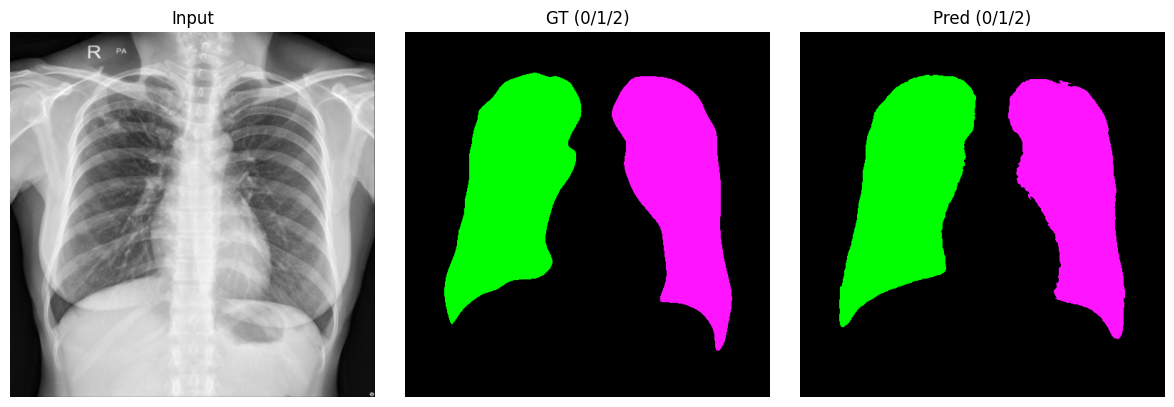

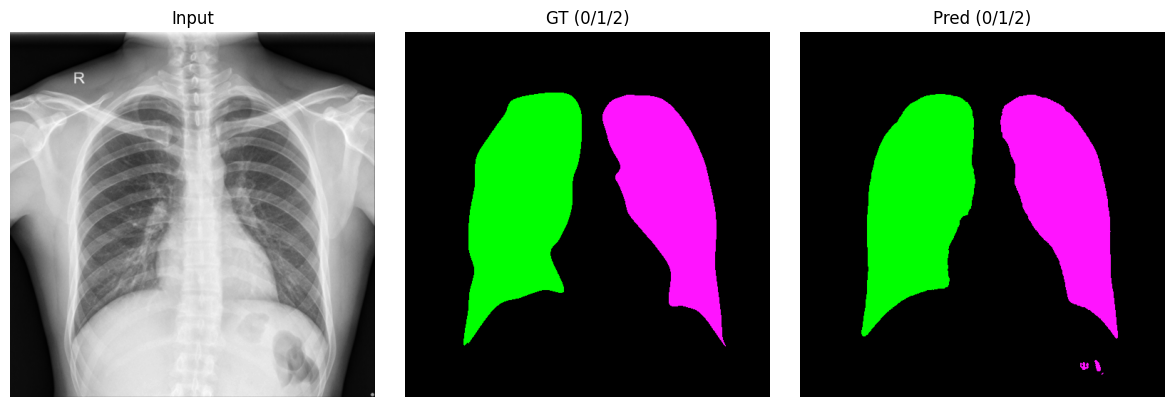

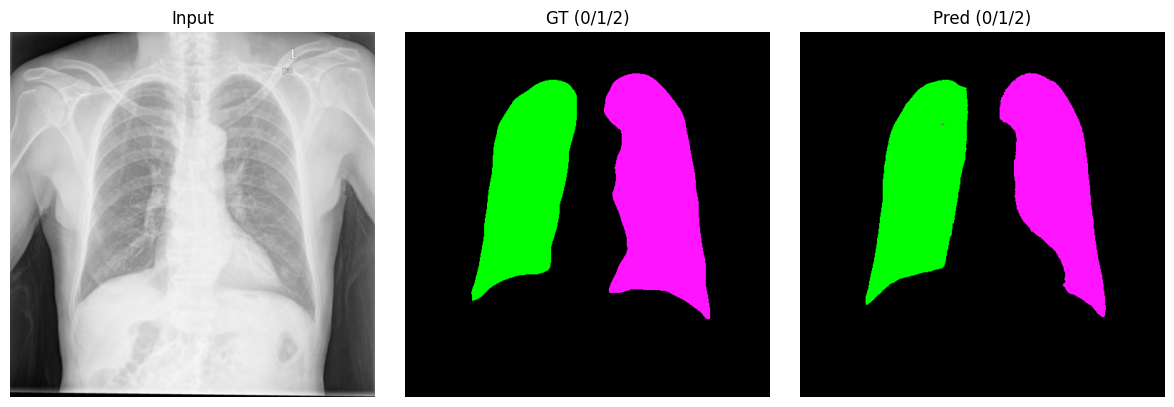

In [105]:
visualize_test_examples(test_loader, n_cases=6)

### Inference

In [106]:
def load_best_model(ckpt_path: Path = cfg.ckpt_path) -> nn.Module:
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    cfg_from_ckpt = ckpt.get("cfg", asdict(cfg))
    model_inf = UNet(
        in_ch=cfg_from_ckpt.get("in_channels", cfg.in_channels),
        num_classes=cfg_from_ckpt.get("num_classes", cfg.num_classes),
        base_ch=cfg_from_ckpt.get("base_channels", cfg.base_channels),
        depth=cfg_from_ckpt.get("depth", cfg.depth),
    )
    model_inf.load_state_dict(ckpt["model_state"])
    model_inf.to(device).eval()
    return model_inf


In [107]:
@torch.no_grad()
def predict_mask(model_inf: nn.Module,
                 img_path: Path,
                 img_size: Tuple[int, int] = cfg.img_size,
                 mean: float = cfg.mean,
                 std: float = cfg.std) -> Tuple[np.ndarray, Image.Image]:

    img = Image.open(img_path).convert("L")
    img_resized = img.resize((img_size[1], img_size[0]), resample=Image.BILINEAR)
    t = TF.to_tensor(img_resized)
    t = TF.normalize(t, [mean], [std])
    t = t.unsqueeze(0).to(device)
    logits = model_inf(t)
    pred = logits.argmax(dim=1)[0].cpu().numpy().astype(np.uint8)
    return pred, img_resized

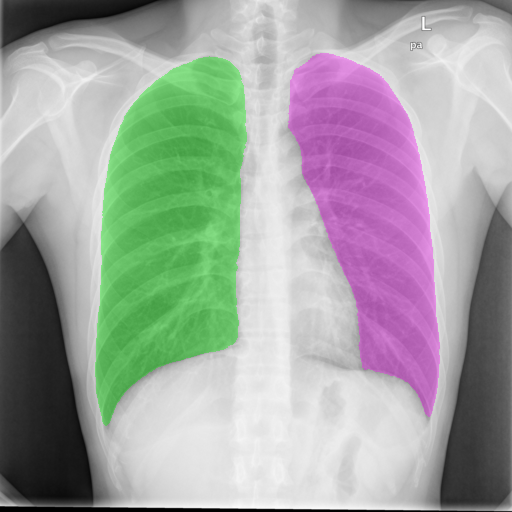

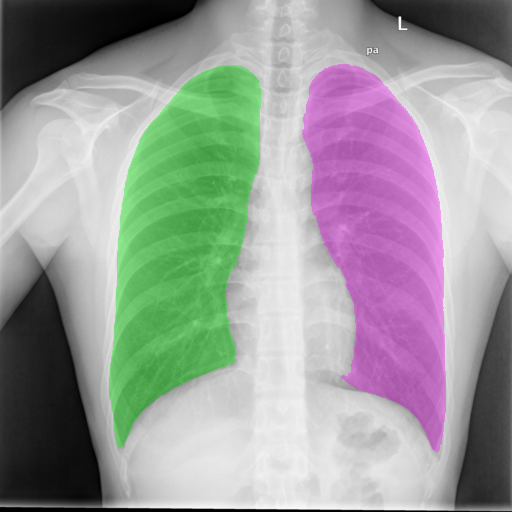

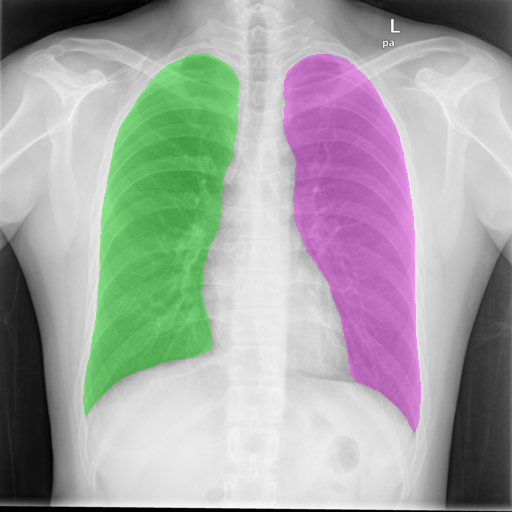

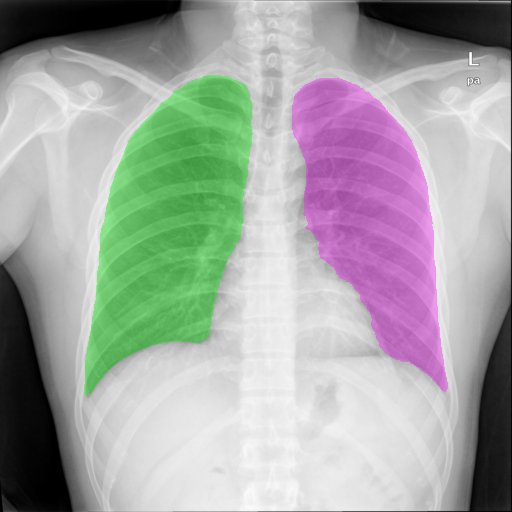

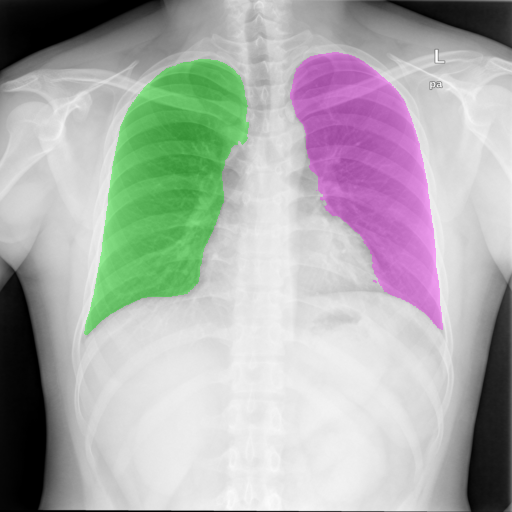

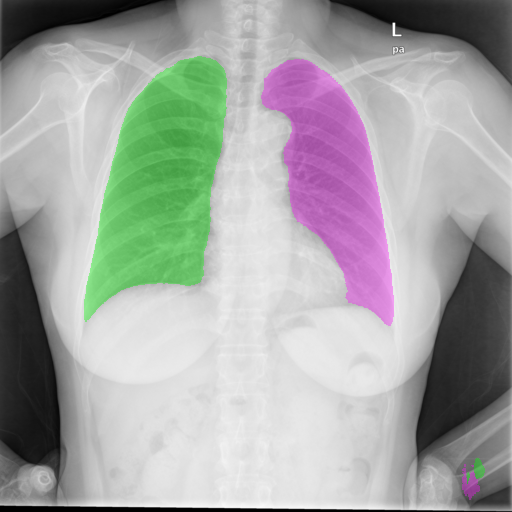

In [108]:
model_best = load_best_model()

filenames = next(os.walk(cfg.inference_dir))[2][:6]
for file in filenames:
    filename = cfg.inference_dir / file
    pred_mask, preproc_img = predict_mask(model_best, filename)
    overlay = overlay_multiclass_on_image(preproc_img, pred_mask, alpha=0.35)
    display(overlay)

<b>P.S. Usually I restart and Clear all Outputs, But For this project I will leave them as is</b>